In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [6]:
train_dir = 'datasets/chest_xray/train'
test_dir = 'datasets/chest_xray/test'

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: datasets/chest_xray/train

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                           shuffle=True, num_workers=4)

In [10]:
test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform)

In [11]:
test_data

Dataset ImageFolder
    Number of datapoints: 624
    Root location: datasets/chest_xray/test

In [12]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=4)

In [13]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [14]:
class_names = train_data.classes

print(class_names)

['NORMAL', 'PNEUMONIA']


In [15]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)

In [16]:
inputs, classes = next(iter(dataloaders['train']))

In [17]:
out = torchvision.utils.make_grid(inputs)

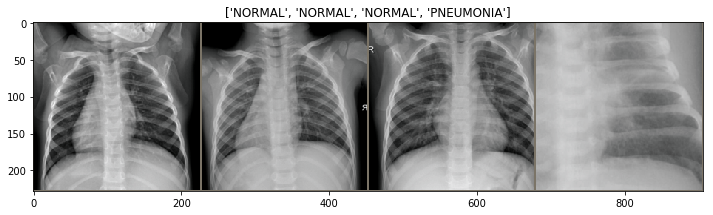

In [18]:
imshow(out, title=[class_names[x] for x in classes])

In [19]:
from torchvision import models

model = models.alexnet()

In [20]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [21]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [22]:
model.classifier[6] = nn.Linear(num_ftrs, 2)

In [23]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [24]:
criterion   = nn.CrossEntropyLoss()

optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
def train_model(model, criterion, optimizer, num_epochs=25):

    model = model.to(device)
    total_step = len(dataloaders['train'])


    for epoch in range(num_epochs):
        print('epoch=',epoch)        

        for i, (images,labels)  in enumerate((dataloaders['train'])):

                images = images.to(device)
                labels = labels.to(device)
    
                outputs = model(images)
                outputs = outputs.to(device)
                loss = criterion(outputs,labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        print('Epoch - %d, loss - %0.5f '\
            %(epoch, loss.item()))

    return model

In [26]:
model = train_model(model, criterion, optimizer, num_epochs=10)

epoch= 0
Epoch [1/10], Step [100/1304], Loss: 0.7427
Epoch [1/10], Step [200/1304], Loss: 0.5918
Epoch [1/10], Step [300/1304], Loss: 0.3095
Epoch [1/10], Step [400/1304], Loss: 0.5737
Epoch [1/10], Step [500/1304], Loss: 0.3585
Epoch [1/10], Step [600/1304], Loss: 0.2985
Epoch [1/10], Step [700/1304], Loss: 0.4564
Epoch [1/10], Step [800/1304], Loss: 0.4169
Epoch [1/10], Step [900/1304], Loss: 0.4756
Epoch [1/10], Step [1000/1304], Loss: 0.5182
Epoch [1/10], Step [1100/1304], Loss: 0.7335
Epoch [1/10], Step [1200/1304], Loss: 0.4580
Epoch [1/10], Step [1300/1304], Loss: 0.5705
Epoch - 0, loss - 0.57832 
epoch= 1
Epoch [2/10], Step [100/1304], Loss: 0.6853
Epoch [2/10], Step [200/1304], Loss: 0.3370
Epoch [2/10], Step [300/1304], Loss: 0.7731
Epoch [2/10], Step [400/1304], Loss: 0.2058
Epoch [2/10], Step [500/1304], Loss: 0.1031
Epoch [2/10], Step [600/1304], Loss: 0.3786
Epoch [2/10], Step [700/1304], Loss: 0.3038
Epoch [2/10], Step [800/1304], Loss: 0.9743
Epoch [2/10], Step [900/130

In [27]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [28]:
with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 87.82051282051282%


Acutal label 1


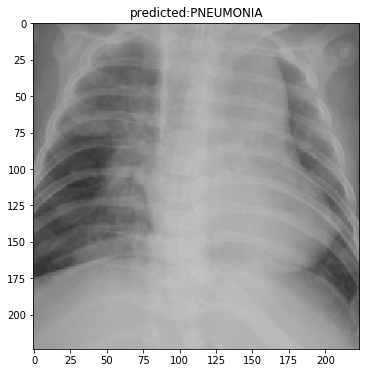

Acutal label 0


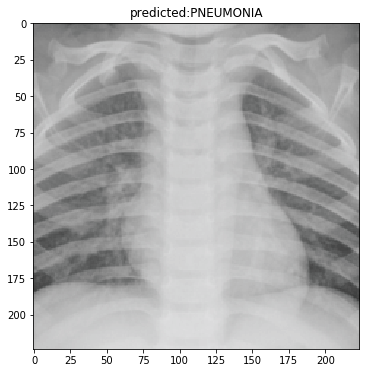

Acutal label 0


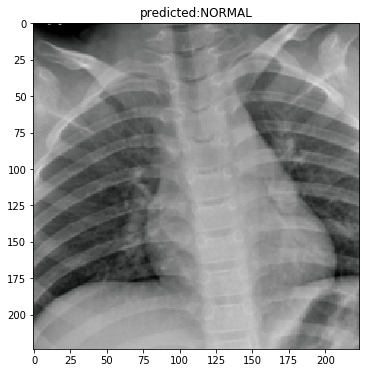

Acutal label 1


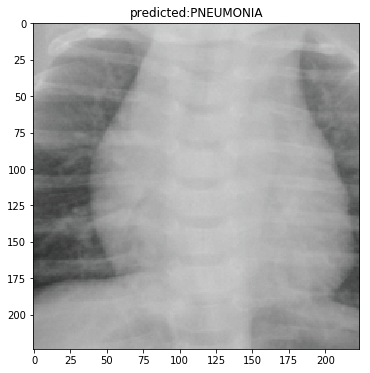

Acutal label 1


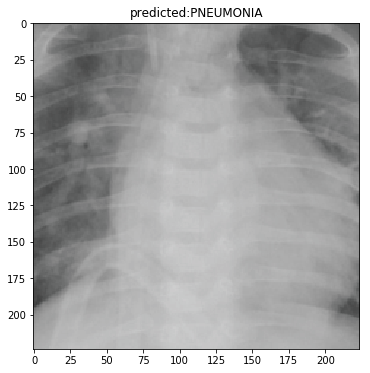

Acutal label 1


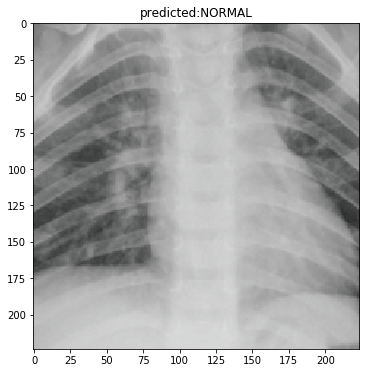

Acutal label 0


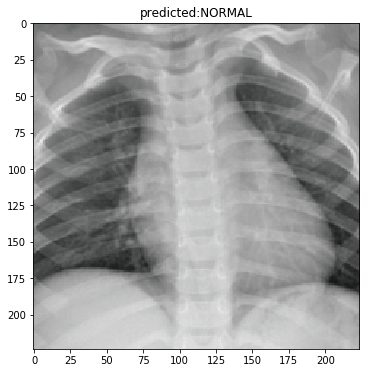

Acutal label 0


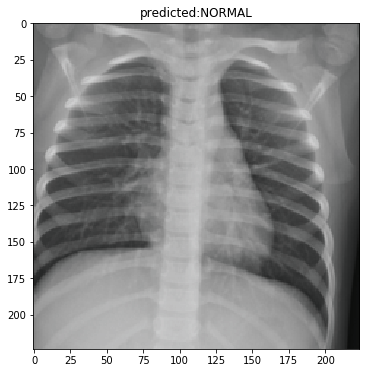

In [29]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Acutal label", np.array(labels)[j])
        
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])